In [2]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('USMTO5.csv', index_col = False)

In [5]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [6]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [7]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [8]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [9]:
USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [10]:
USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [11]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [12]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [13]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [14]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)

In [15]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

In [16]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 100]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


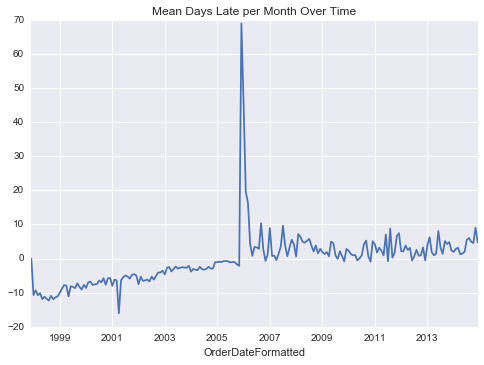

In [17]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

In [18]:
#possible causes of change in oscillation
#box and whisker plots - how distribution changed over time
#change of median, edge, etc?
#potential companies that may have joined around 2005


In [19]:
#restricts Backfill table to suspicious DaysLate years

USMTO_NO_SUBMIT_BACKFILL_2005_2006 = USMTO_NO_SUBMIT_BACKFILL[USMTO_NO_SUBMIT_BACKFILL.EntryYear.between(2005,2006,inclusive = 'True')]

In [20]:
#Investigation of LateDays Spike in 2005. Exhibit 1B, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL_2005_2006.groupby(['EntryYear','EntryMonth'])['DaysLate'].mean()

EntryYear  EntryMonth
2005       1             -1.038743
           2             -0.920645
           3             -0.986988
           4             -0.715517
           5             -0.698100
           6             -0.815088
           7             -1.119292
           8             -0.958098
           9             -1.109884
           10            -1.700811
           11            -2.123443
           12            68.936944
2006       1             45.552290
           2             19.586794
           3             16.392118
           4              4.217175
           5              0.811528
           6              3.440760
           7              3.284892
           8              2.874966
           9             10.388842
           10             2.791005
           11            -0.653747
           12             1.196773
Name: DaysLate, dtype: float64

In [21]:
#Further investigation into Dec 2005 to March 2006

USMTO_NO_SUBMIT_BACKFILL_2005_2006_RESTRICT = USMTO_NO_SUBMIT_BACKFILL[USMTO_NO_SUBMIT_BACKFILL.OrderDateFormatted.between('2005-12-01','2006-03-01',inclusive = 'True')]
Export = USMTO_NO_SUBMIT_BACKFILL_2005_2006_RESTRICT.groupby(['EntryYear','EntryMonth','AAID'])['DaysLate'].mean()
Export.to_csv('Suspicious Records 2005-2006')

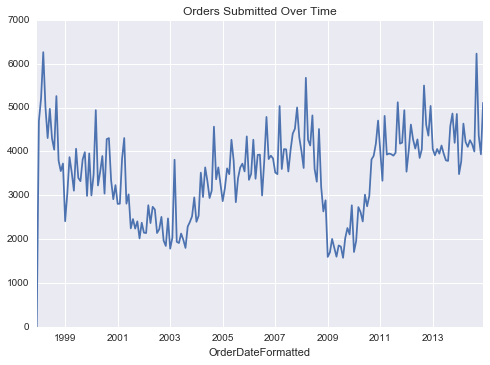

In [22]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

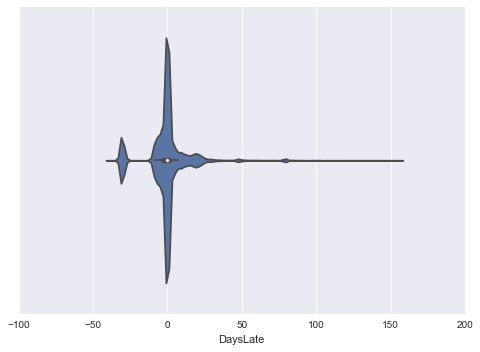

In [23]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


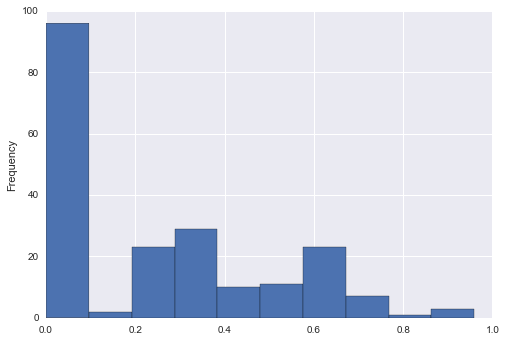

In [38]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailOne'].mean().plot(kind = 'hist',bins = 10)

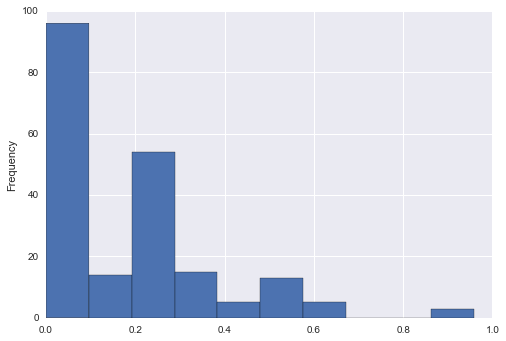

In [39]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailTwo'].mean().plot(kind = 'hist',bins = 10)

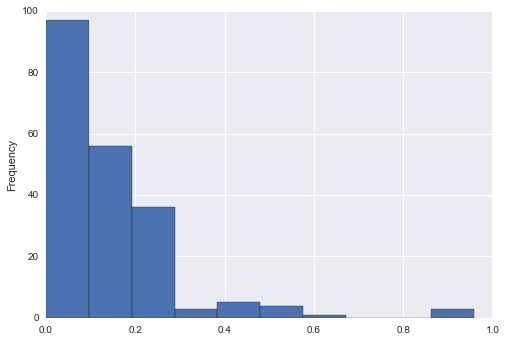

In [40]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsCall'].mean().plot(kind = 'hist',bins = 10)

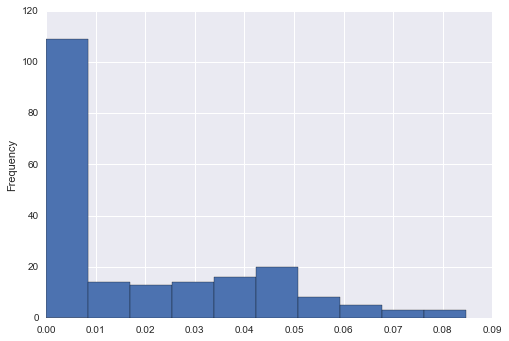

In [41]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsBackfill'].mean().plot(kind = 'hist',bins = 10)

In [29]:
USMTO_WHOLE.columns

Index(['OrderID', 'AAID', 'NAICSID', 'CustomerZipCode', 'ShippingCountryID',
       'ShippingZipCode', 'Units', 'TotalSale', 'CreatedBy', 'CreateDate',
       'ChangedBy', 'IsSubmitted', 'TopCategoryName', 'SubCategory',
       'SubCategoryName', 'Description', 'MachineCode', 'EntryMonth',
       'EntryYear', 'OrderDateFormatted', 'ChangedDateFormatted',
       'SubmitDateFormatted', 'OrderDateEOM', 'DaysLate', 'IsEmailOne',
       'IsEmailTwo', 'IsCall', 'IsBackfill'],
      dtype='object')

In [51]:
#Days late by company, by month

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)


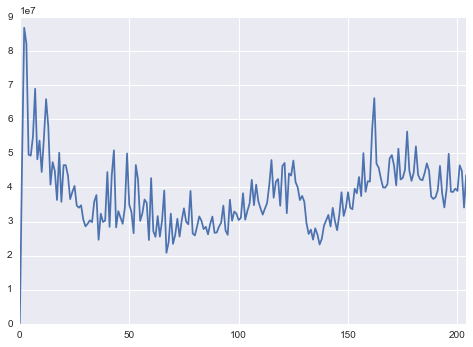

In [88]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.TotalSale.plot(kind = 'line')

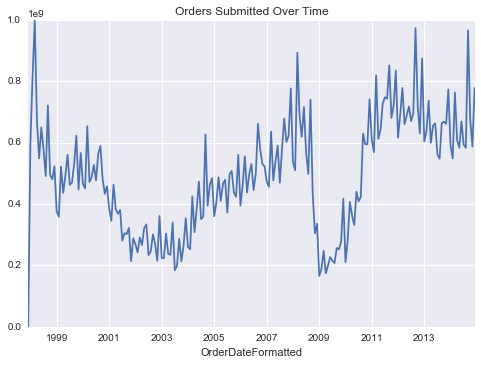

In [87]:
USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

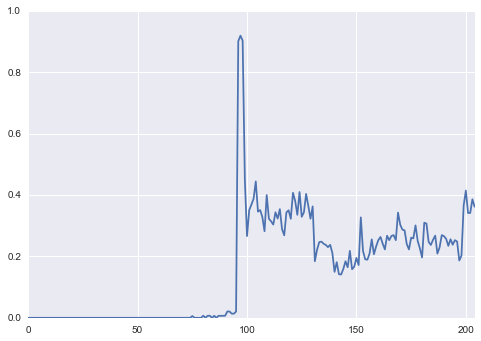

In [84]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.IsCall.plot(kind = 'line')

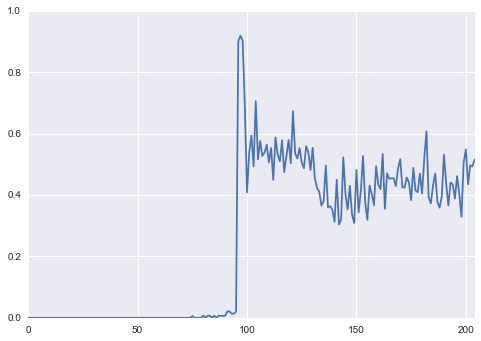

In [80]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.IsEmailOne.plot(kind = 'line')

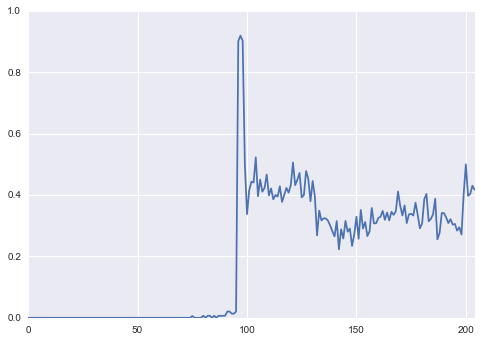

In [81]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.IsEmailTwo.plot(kind = 'line')

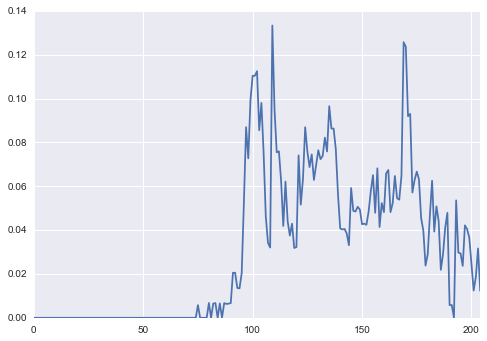

In [82]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.IsBackfill.plot(kind = 'line')

<bound method FramePlotMethods.scatter of <pandas.tools.plotting.FramePlotMethods object at 0x000000005C1F3CC0>>

In [31]:
AAIDs = pd.DataFrame.from_csv('AAIDs.csv', index_col = False)

In [32]:
AAIDs = AAIDs.fillna('')

In [33]:
AAIDs

,Unique AAID,Unique Dates,Index
0,123,1-1997,123 1-1997
1,100001,2-1997,100001 2-1997
2,100002,3-1997,100002 3-1997
3,100004,4-1997,100004 4-1997
4,100005,5-1997,100005 5-1997
5,100007,6-1997,100007 6-1997
6,100009,7-1997,100009 7-1997
7,100010,8-1997,100010 8-1997
8,100011,9-1997,100011 9-1997
9,100012,10-1997,100012 10-1997


In [34]:
b = a[(x, y) for x in AAIDs['Unique AAID'] for y in AAIDs['Unique Dates']]


SyntaxError: invalid syntax (<ipython-input-34-8df4ddfb6cfd>, line 1)

In [ ]:
a.count('Unique AAID')